# Goal

The goal of this project to to automate the ** process of identifying the dynamic microtublues (mt) that grow from axonemal microtubules (seed) **. This will help to measure the dynamic microtubules length and facilitate in identifying microtuble plus and minus ends.

In [1]:
# most modules that this program needs

import pandas as pd
import glob, os
import mahotas as mh
import numpy as np
import matplotlib as mpl

from pylab import imshow
from skimage import io
import skimage
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

# The following part is an example for demonstration

The axoneme is labeled with GFP (green) and the dynamic microtuble is labeled with mCherry (red).
Notice that this photo is relative noise.

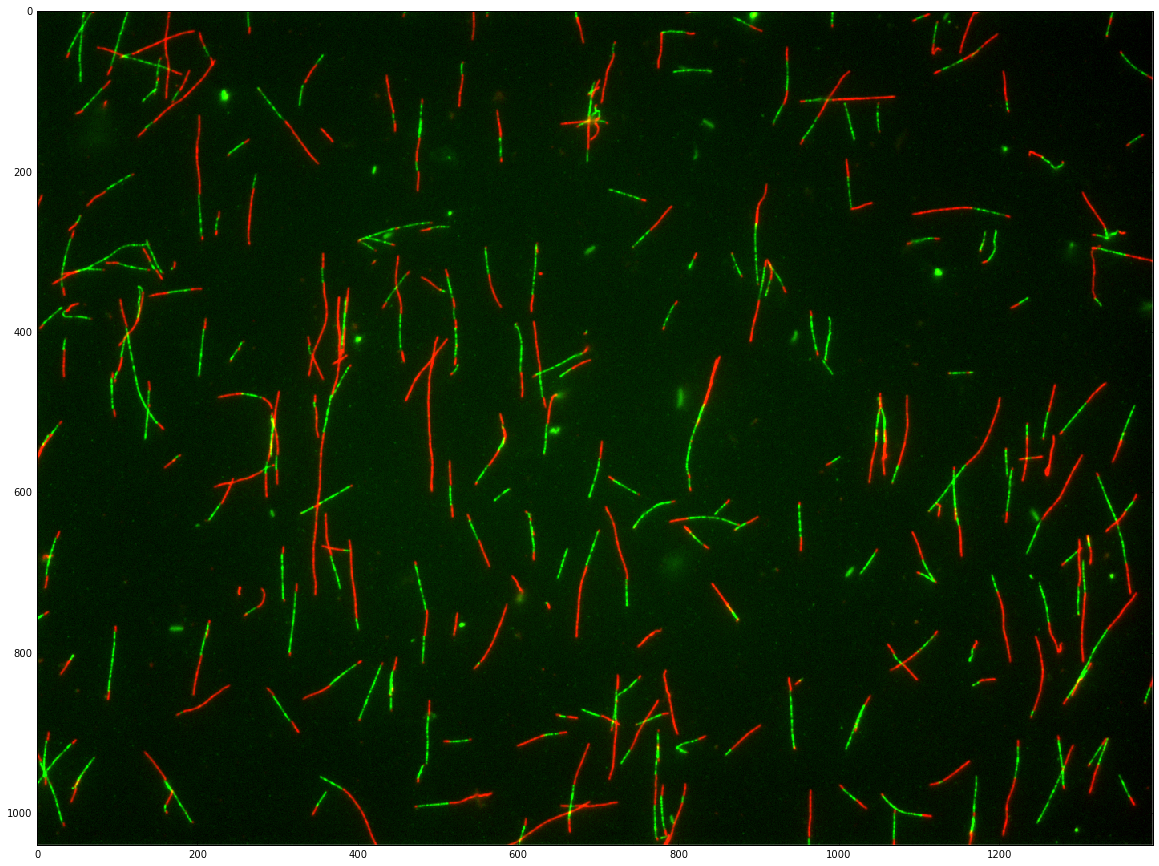

In [2]:
# Read the tif file

image = io.imread('2016-0328-E11.E12 composite- worst.tif')
fig = plt.figure(figsize = (20, 15))
imshow(image)

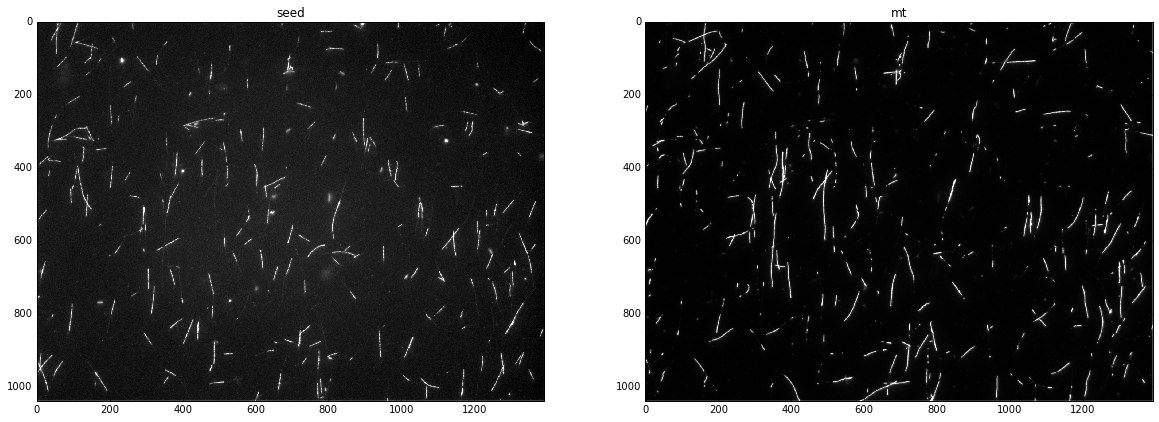

In [7]:
# Seperate the green and red channels. Notice that the green channel is way noiser than the red channel

seed = image[..., 1] # green channel
mt = image[..., 0] # red channel

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 16))

ax1.imshow(seed)
ax1.set_title('seed')
ax2.imshow(mt)
ax2.set_title('mt')

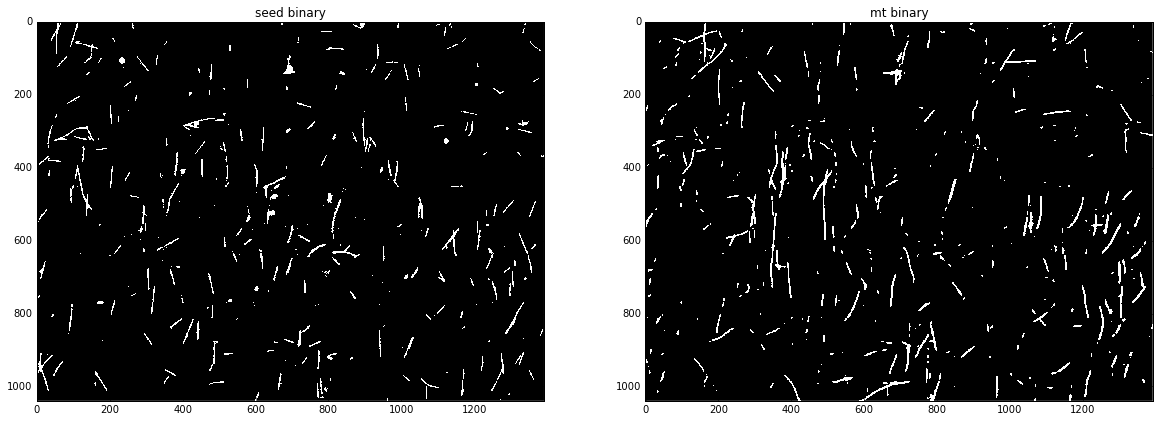

In [8]:
# Use the yen thresholding to make binaries, again the binary photos contains lots of 'noise'.
from skimage import filters

mt_mask = skimage.filters.threshold_yen(mt)
mt_f = (mt > mt_mask)

seed_mask = skimage.filters.threshold_yen(seed)
seed_f = (seed > seed_mask)


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 16))

ax1.imshow(seed_f)
ax1.set_title('seed binary')
ax2.imshow(mt_f)
ax2.set_title('mt binary')

In [ ]:
# One potential strategy is to use skel recognization. However, it doesn't work particularly good.

import skimage.morphology

composite_f = np.maximum(seed_f, mt_f)
skel, distance = skimage.morphology.medial_axis(composite_f, return_distance = True)
dist_on_skel = distance * skel

fig, ax1 = plt.subplots(1, 1, figsize = (20, 15))
ax1.imshow(dist_on_skel, cmap = plt.cm.spectral)

plt.show()

In [26]:
# We choose another strategy, watershedding.

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

# Label individual mt using watershed and local maximum

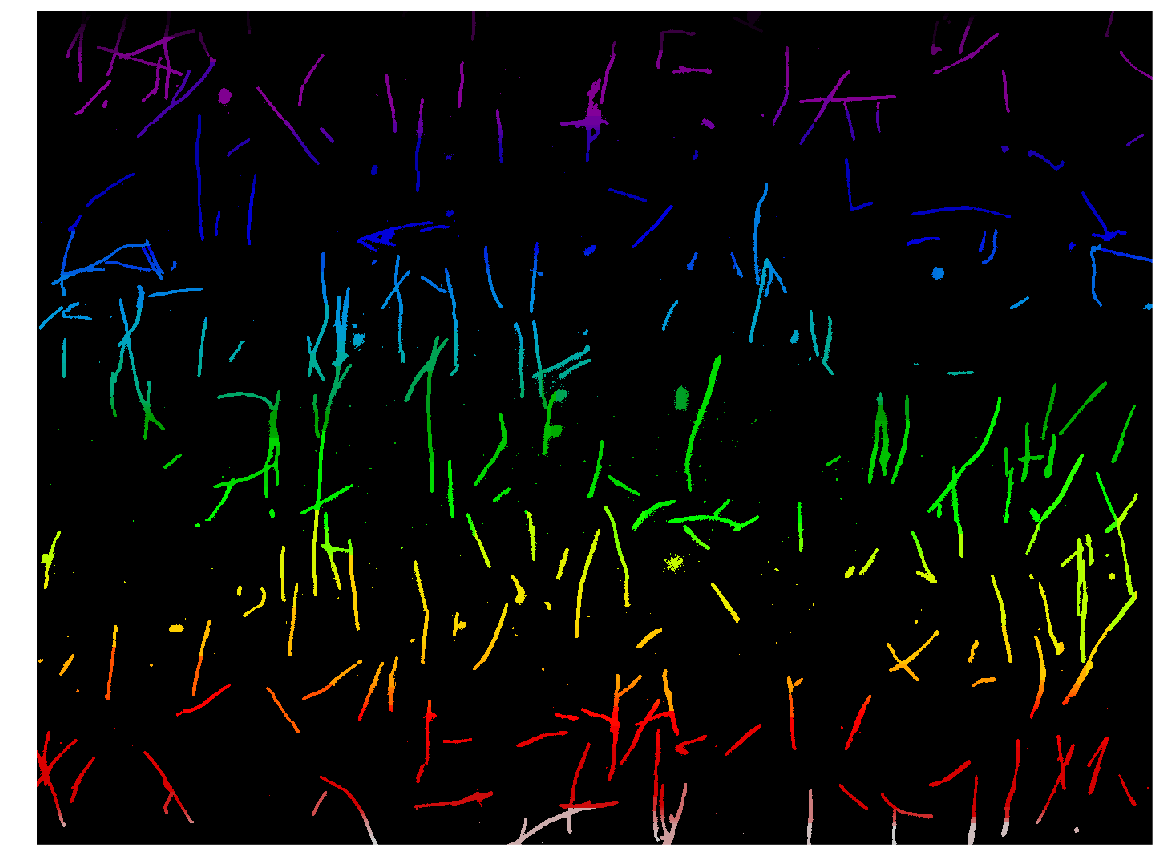

In [27]:
# We create a composite_binary by max(seed_binary, mt_binary).
# Label the composite

composite_f = np.maximum(seed_f, mt_f)

distance = ndi.distance_transform_edt(composite)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=composite_f)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=composite_f)

fig, ax = plt.subplots(1, 1, figsize = (20, 15))

ax.set_axis_off()
ax.imshow(labels, cmap = 'spectral')

# Notice that the object labelling is still not very good. (Different color indicates different objects.)

# Refine labeling with Mahotas.label and size selection

There are 68 microtubules (seed + dynamic mt) detected


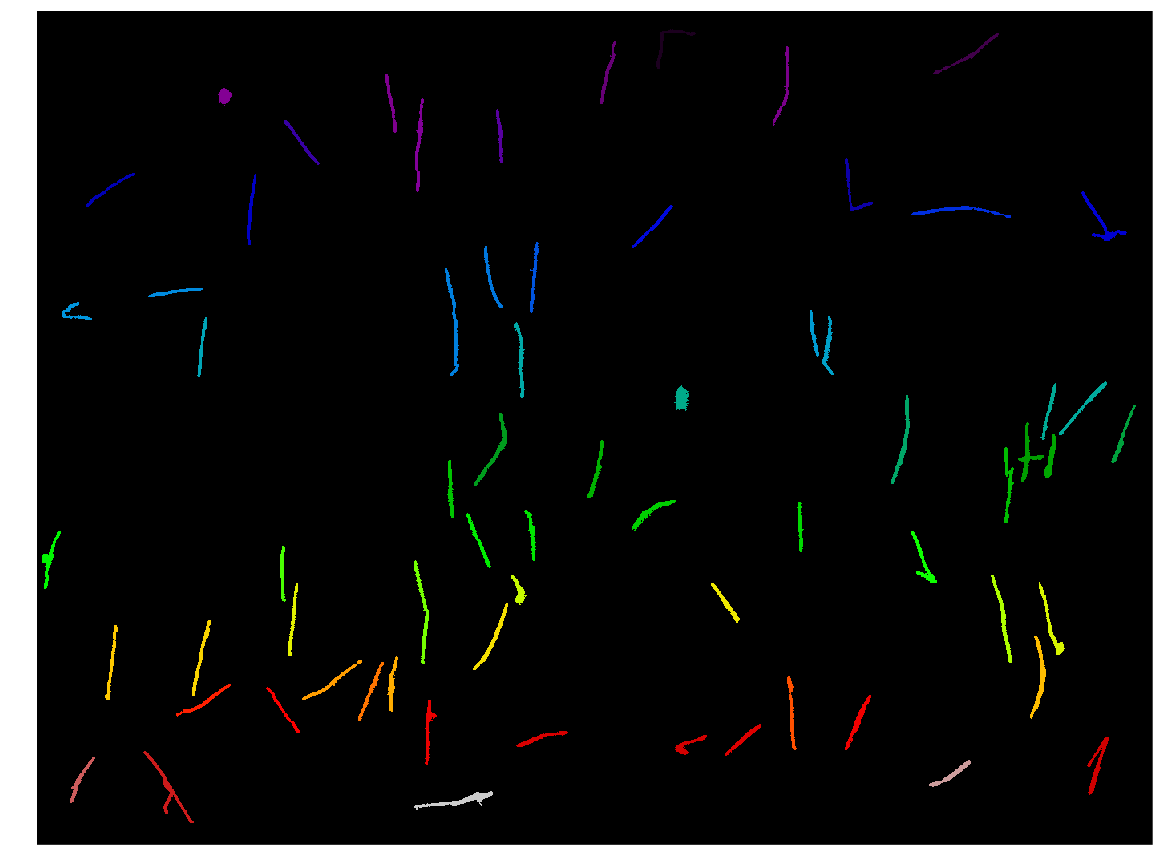

In [35]:
min_size = 250
max_size = 600


import mahotas as mh

labeled, number_mt = mh.label(labels)

#Remove congregated nuclei and micronuclei
sizes = mh.labeled.labeled_size(labeled)
too_big = np.where(sizes > max_size)
labeled = mh.labeled.remove_regions(labeled, too_big)
too_small = np.where(sizes < min_size)
labeled = mh.labeled.remove_regions(labeled, too_small)

# Remove cells at the borders
labeled = mh.labeled.remove_bordering(labeled)

# Relabel everthing
relabeled, n_final = mh.labeled.relabel(labeled)

# Nuclear size
sizes = mh.labeled.labeled_size(relabeled)

fig, ax = plt.subplots(1, 1, figsize = (20, 15))

ax.set_axis_off()
ax.imshow(relabeled, cmap = 'spectral')

print('There are %d microtubules (seed + dynamic mt) detected' %n_final)

# Notice that the identified objects include some blobs and crosses

## The next step is to identify the dynamic mt and measure the length.

In [103]:
%%time
from scipy.misc import imsave

result_dict = {}
for i in range(1, n_final):
    mask = relabeled == i
    
    labeled, number_mt = mh.label(mask & mt_f)
    sizes = mh.labeled.labeled_size(labeled)
    if len(sizes) == 3:
        result_dict[i] = sorted(sizes[1:].tolist(), reverse = True)
        imsave('dynamic_MT_%s.png' %i, mask & mt_f)

CPU times: user 3.63 s, sys: 669 ms, total: 4.3 s
Wall time: 4.38 s


## Save the measurements

In [110]:
mt_analysis = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in result_dict.items()])).transpose()
mt_analysis.columns = ['+end', '-end']
mt_analysis.head()

,+end,-end
1,207,49
3,289,16
5,209,58
8,156,25
10,128,103


In [111]:
mt_analysis.to_csv('measurement_result.csv')